In [1]:
# from azureml.core import Workspace
import pandas as pd
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os

# Loading Data

In [2]:
# Loading the Dataset
df1 = pd.read_csv('airbnb_nyc.csv')
df1.head()

,Unnamed: 0,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,Superhost,host_neighbourhood,host_listings_count,...,minimum_nights,maximum_nights,availability_365,calendar_last_scraped,number_of_reviews,Review_Rating,review_scores_cleanliness,review_scores_value,instant_bookable,Review Rating
0,0,918239,4930847,2/1/2013,a few days or more,20%,0,No,Williamsburg,1,...,1,90,64,12/6/2019,114,95,9,10,f,4th Quartile
1,1,918426,4932354,2/1/2013,within an hour,100%,0,Yes,Prospect Heights,4,...,3,14,134,12/6/2019,80,93,9,10,f,4th Quartile
2,2,919491,4938247,2/2/2013,within a day,100%,0,No,Park Slope,1,...,2,180,0,12/5/2019,175,93,9,9,f,4th Quartile
3,3,919830,1895793,3/10/2012,within an hour,100%,0,Yes,Chelsea,1,...,2,7,167,12/6/2019,176,96,10,10,t,4th Quartile
4,4,919955,794794,7/8/2011,within a day,67%,0,No,Upper East Side,1,...,14,1124,354,12/6/2019,11,96,9,9,f,4th Quartile


In [3]:
# Dumping all irrelevant columns
df = df1.drop(['id','neighbourhood', 'Review Rating','host_since', 'host_response_time','amenities',
               'street', 'host_verifications','calendar_last_scraped','host_identity_verified',  'host_has_profile_pic', 
               'neighbourhood_cleansed',  'instant_bookable','host_acceptance_rate', 'host_id', 'host_listings_count', 
               'host_total_listings_count', 'minimum_nights', 'maximum_nights', 'property_type', 'host_neighbourhood', 'Unnamed: 0'], axis = 1)

In [4]:
# Checking for nulls 
df.isnull().sum()

host_response_rate           0
Superhost                    0
Borough                      0
latitude                     0
longitude                    0
Room_Type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
bed_type                     0
Price                        0
weekly_price                 0
monthly_price                0
security_deposit             0
cleaning_fee                 0
guests_included              0
extra_people                 0
availability_365             0
number_of_reviews            0
Review_Rating                0
review_scores_cleanliness    0
review_scores_value          0
dtype: int64

In [5]:
# inspeting the all the columns datatypes
df.head().T

,0,1,2,3,4
host_response_rate,20%,100%,100%,100%,67%
Superhost,No,Yes,No,Yes,No
Borough,Brooklyn,Brooklyn,Brooklyn,Manhattan,Manhattan
latitude,40.7016,40.6785,40.6767,40.746,40.764
longitude,-73.9435,-73.9701,-73.9792,-73.9991,-73.9639
Room_Type,Private room,Private room,Private room,Private room,Entire home/apt
accommodates,1,2,4,2,3
bathrooms,1,1,1,1,1
bedrooms,1,1,1,1,1
beds,0,1,2,1,1


In [6]:
# Transforming and casting to numerical data type
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(int)
df['extra_people'] = df['extra_people'].str.replace('$', '').str.replace(',', '').str.strip().astype(float)
df['weekly_price'] = df['weekly_price'].str.replace('$', '').str.replace(',', '').str.strip().astype(float)
df['monthly_price'] = df['monthly_price'].str.replace('$', '').str.replace(',', '').str.strip().astype(float)
df['bathrooms'] = df['bathrooms'].astype(float)
df['bedrooms'] = df['bedrooms'].astype(float)

In [7]:
# # Creating Location column from lat-long
# cols =['latitude', 'longitude']
# df['location'] = df[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
# df['location'] =  df['location'].apply(lambda row: tuple(map(float, row.split(', '))))

In [8]:
# checking visually the columns data type
df.head().T

,0,1,2,3,4
host_response_rate,20,100,100,100,67
Superhost,No,Yes,No,Yes,No
Borough,Brooklyn,Brooklyn,Brooklyn,Manhattan,Manhattan
latitude,40.7016,40.6785,40.6767,40.746,40.764
longitude,-73.9435,-73.9701,-73.9792,-73.9991,-73.9639
Room_Type,Private room,Private room,Private room,Private room,Entire home/apt
accommodates,1,2,4,2,3
bathrooms,1,1,1,1,1
bedrooms,1,1,1,1,1
beds,0,1,2,1,1


Data Exploration

In [9]:
# checking the columns data type
df.dtypes

host_response_rate             int32
Superhost                     object
Borough                       object
latitude                     float64
longitude                    float64
Room_Type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                           int64
bed_type                      object
Price                        float64
weekly_price                 float64
monthly_price                float64
security_deposit               int64
cleaning_fee                   int64
guests_included                int64
extra_people                 float64
availability_365               int64
number_of_reviews              int64
Review_Rating                  int64
review_scores_cleanliness      int64
review_scores_value            int64
dtype: object

In [10]:
# Removinf price outliers
df = df[df['Price'] <400]
len(df)

48568

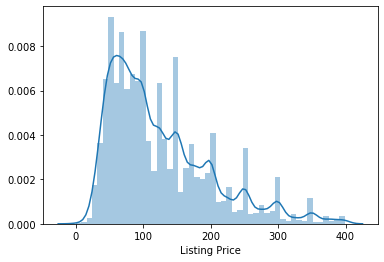

In [11]:
# Plotting the distribution of the price
ax = sb.distplot(df['Price'], axlabel='Listing Price')

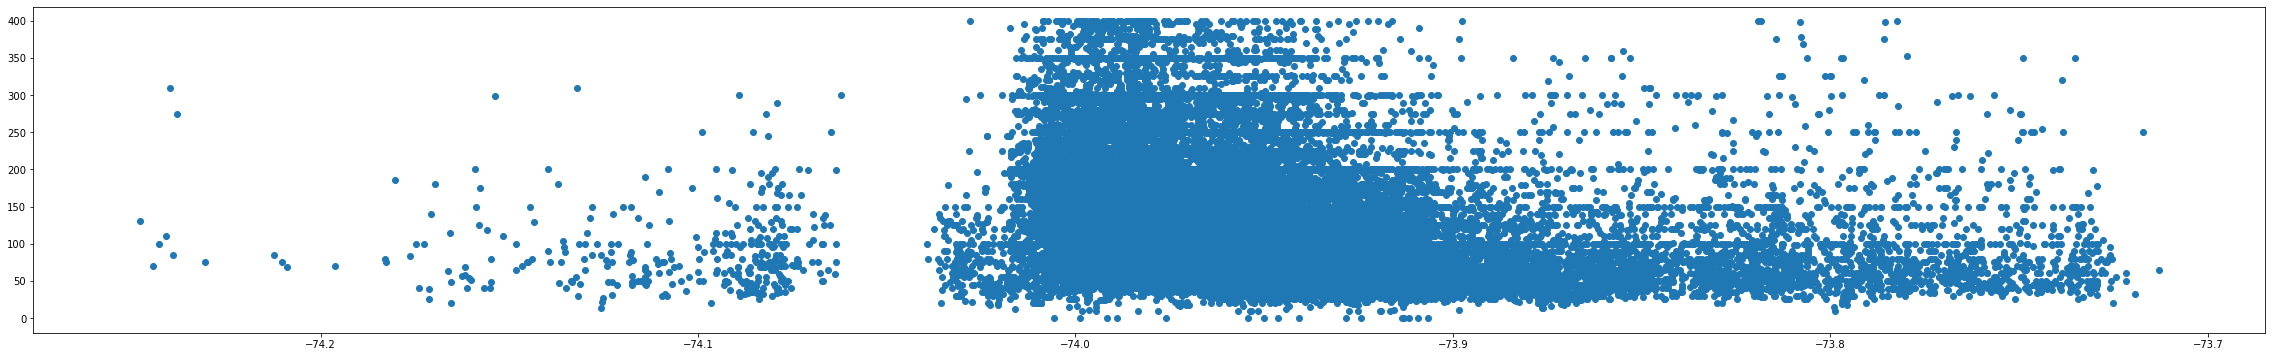

In [12]:
# Price vs location
plt.figure(figsize=(40,6))
plt.scatter(df['longitude'], df['Price'])

In [13]:
# Calculating the Distance from Time Square 
import geopy.distance

cols =['latitude', 'longitude']
df['location'] = df[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
df['location'] =  df['location'].apply(lambda row: tuple(map(float, row.split(', '))))

# Time Square Location
coords = (40.758896, -73.985130)
df['distance'] =  df['location'].apply(lambda row: geopy.distance.vincenty(coords, row).miles)
# print geopy.distance.vincenty(coords_1, coords_2).km
df['distance']

c:\users\cheikh_moctar\documents\ucf_bootcamp\ripos_git\class_repo\env\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # Remove the CWD from sys.path while we load stuff.


0        4.518910
1        5.602132
2        5.683554
3        1.148927
4        1.170857
           ...   
50594    6.538442
50595    2.457599
50596    1.888921
50597    1.432552
50598    5.804301
Name: distance, Length: 48568, dtype: float64

In [14]:
# Creating coorelation between all features
corr = df.corr()
corr

,host_response_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,Price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,availability_365,number_of_reviews,Review_Rating,review_scores_cleanliness,review_scores_value,distance
host_response_rate,1.000000,-0.016446,0.108878,0.143451,0.062316,0.075463,0.128480,0.049112,-0.063643,0.012111,0.057280,0.217384,0.150527,0.128986,0.457889,0.291689,0.221325,0.236799,0.217586,0.095864
latitude,-0.016446,1.000000,0.081726,-0.047781,-0.077362,-0.082149,-0.059592,0.073582,-0.003112,0.010841,0.020213,0.021597,-0.063224,-0.002079,-0.008316,-0.014460,-0.033557,-0.033439,-0.035886,-0.414800
longitude,0.108878,0.081726,1.000000,0.021202,0.036392,0.066045,0.035939,-0.300487,-0.076594,-0.063068,-0.084781,-0.169428,0.051897,0.024546,0.091408,0.055670,0.038622,0.046144,0.044873,0.548592
accommodates,0.143451,-0.047781,0.021202,1.000000,0.211702,0.605421,0.732416,0.506038,0.065975,0.073015,0.129372,0.393048,0.560641,0.097604,0.127140,0.096231,0.070356,0.078527,0.067415,0.055178
bathrooms,0.062316,-0.077362,0.036392,0.211702,1.000000,0.284194,0.243485,0.083103,0.019751,0.008365,0.029395,0.092781,0.118251,0.019589,0.094527,-0.022754,-0.037086,-0.038931,-0.035117,0.064833
bedrooms,0.075463,-0.082149,0.066045,0.605421,0.284194,1.000000,0.595385,0.306098,0.064941,0.061234,0.081553,0.251460,0.395785,0.077771,0.063093,0.033188,0.017655,0.020933,0.018793,0.122461
beds,0.128480,-0.059592,0.035939,0.732416,0.243485,0.595385,1.000000,0.351525,0.057692,0.063937,0.098347,0.298870,0.465984,0.095997,0.132556,0.076780,0.053547,0.059543,0.052005,0.088439
Price,0.049112,0.073582,-0.300487,0.506038,0.083103,0.306098,0.351525,1.000000,0.135550,0.109931,0.202200,0.469421,0.307392,0.064427,0.066681,-0.037205,-0.036951,-0.028091,-0.051210,-0.364724
weekly_price,-0.063643,-0.003112,-0.076594,0.065975,0.019751,0.064941,0.057692,0.135550,1.000000,0.614312,0.093857,0.087457,0.079700,0.073328,-0.003849,0.114679,0.062220,0.058979,0.058624,-0.056300
monthly_price,0.012111,0.010841,-0.063068,0.073015,0.008365,0.061234,0.063937,0.109931,0.614312,1.000000,0.146669,0.135147,0.077555,0.071760,0.074489,0.143245,0.076990,0.076350,0.071025,-0.063157


Text(0.5, 1, 'Correlation HeatMap')

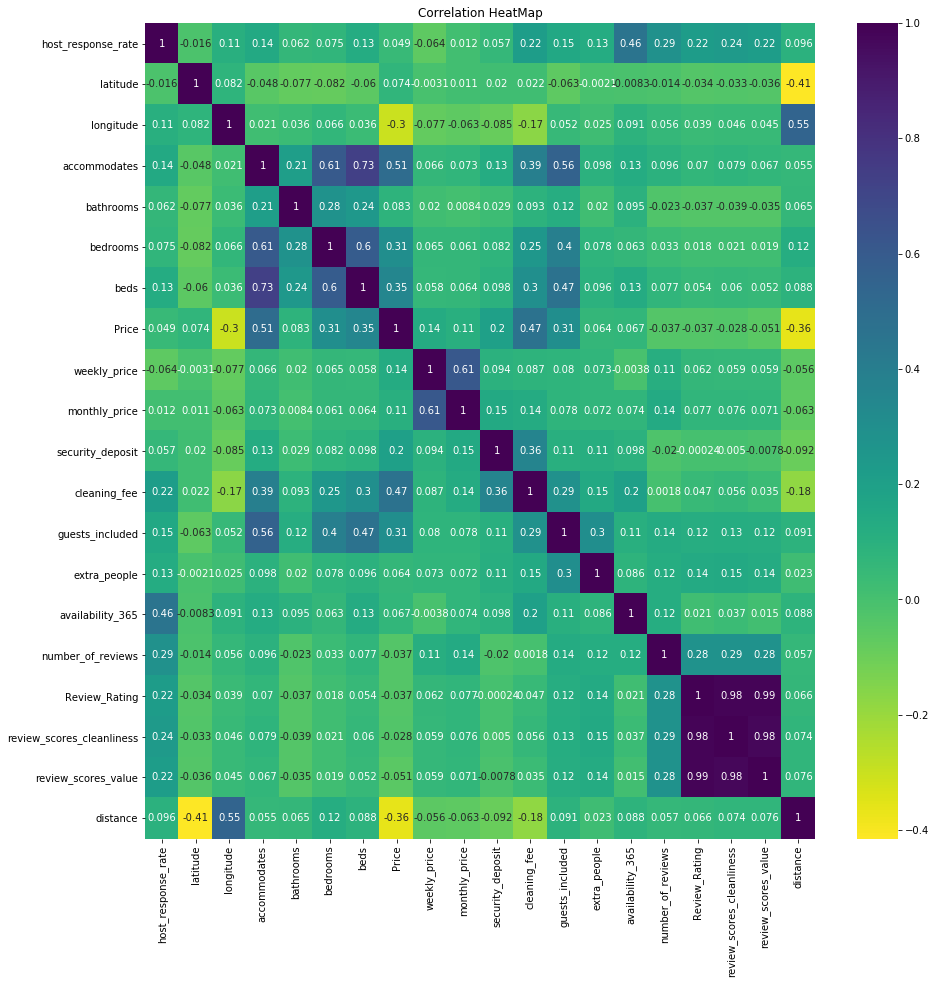

In [15]:
plt.figure(figsize=(15, 15))
corr = df.corr()
sb.heatmap(corr, annot=True, cmap = 'viridis_r')
plt.title('Correlation HeatMap')

Text(0.5, 1.0, 'Price vs distance')

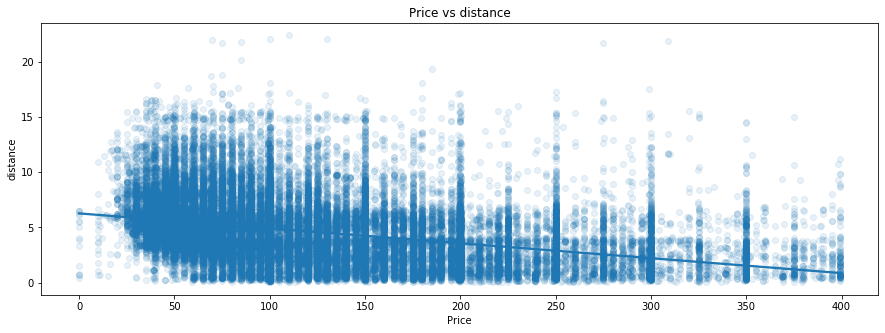

In [16]:
# Price vs Distance

plt.figure(figsize=(15, 5))
sb.regplot(data = df, x = "Price", y = 'distance', x_jitter = 0.1, 
            scatter_kws = {'alpha': 0.1})
plt.title('Price vs distance')

# Borough Exploratory and Analysis

In [17]:
Manhattan = df[df['Borough'] == 'Manhattan']
Brooklyn= df[df['Borough'] == 'Brooklyn']
Bronx = df[df['Borough'] == 'Bronx']
Queens = df[df['Borough'] == 'Queens']
StatenIsland = df[df['Borough'] == 'Staten Island']

In [18]:
Queens

,host_response_rate,Superhost,Borough,latitude,longitude,Room_Type,accommodates,bathrooms,bedrooms,beds,...,cleaning_fee,guests_included,extra_people,availability_365,number_of_reviews,Review_Rating,review_scores_cleanliness,review_scores_value,location,distance
16,100,No,Queens,40.70715,-73.81468,Entire home/apt,2,1.0,1.0,1,...,54,1,15.0,207,88,93,9,9,"(40.70715, -73.81468000000001)",9.633027
24,0,No,Queens,40.75444,-73.83057,Private room,2,1.0,1.0,1,...,13,1,15.0,0,75,94,10,9,"(40.75444, -73.83057)",8.115739
49,100,Yes,Queens,40.70990,-73.91509,Entire home/apt,2,1.0,1.0,1,...,25,2,100.0,311,80,95,10,10,"(40.7099, -73.91509)",4.994522
59,100,No,Queens,40.76356,-73.88850,Entire home/apt,4,1.0,1.0,1,...,55,2,15.0,1,165,90,9,9,"(40.76356, -73.8885)",5.080128
73,100,No,Queens,40.75751,-73.91678,Entire home/apt,2,1.0,1.0,1,...,60,1,10.0,318,292,88,9,9,"(40.757509999999996, -73.91678)",3.587583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50496,70,No,Queens,40.76014,-73.81146,Private room,2,1.0,1.0,1,...,10,1,20.0,353,43,92,9,9,"(40.76014, -73.81146)",9.112648
50516,0,No,Queens,40.76488,-73.92970,Entire home/apt,2,1.0,1.0,1,...,100,2,25.0,126,0,0,0,0,"(40.76488, -73.9297)",2.937405
50564,100,Yes,Queens,40.75088,-73.81029,Private room,1,1.5,1.0,1,...,0,1,0.0,0,128,97,10,10,"(40.75088, -73.81029000000001)",9.190927
50565,100,Yes,Queens,40.75250,-73.81126,Entire home/apt,3,1.0,0.0,2,...,0,2,10.0,312,337,94,9,10,"(40.7525, -73.81126)",9.133928


Text(0.5, 1.0, 'Price vs distance')

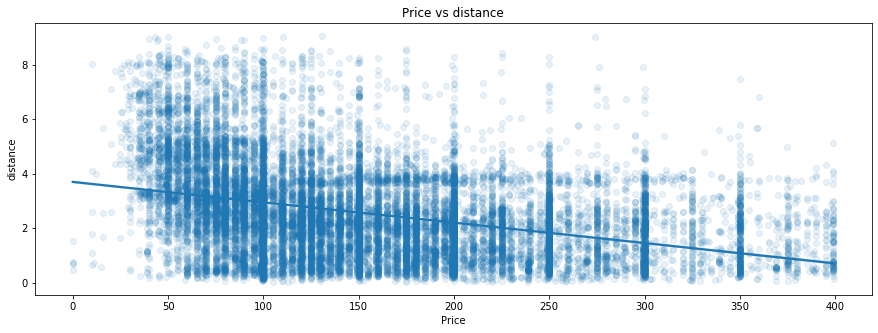

In [19]:
# Price vs Distance Manahattan

plt.figure(figsize=(15, 5))
sb.regplot(data = Manhattan, x = "Price", y = 'distance', x_jitter = 0.1, 
            scatter_kws = {'alpha': 0.1})
plt.title('Price vs distance')

Text(0.5, 1.0, 'Price vs distance')

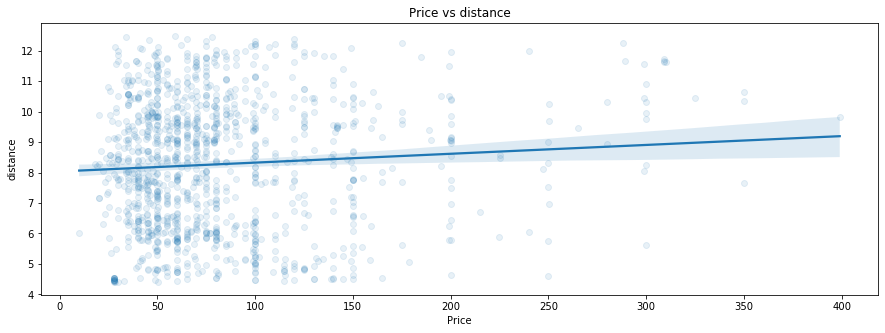

In [20]:
# Price vs Distance Bronx

plt.figure(figsize=(15, 5))
sb.regplot(data = Bronx, x = "Price", y = 'distance', x_jitter = 0.1, 
            scatter_kws = {'alpha': 0.1})
plt.title('Price vs distance')

Text(0.5, 1.0, 'Price vs distance')

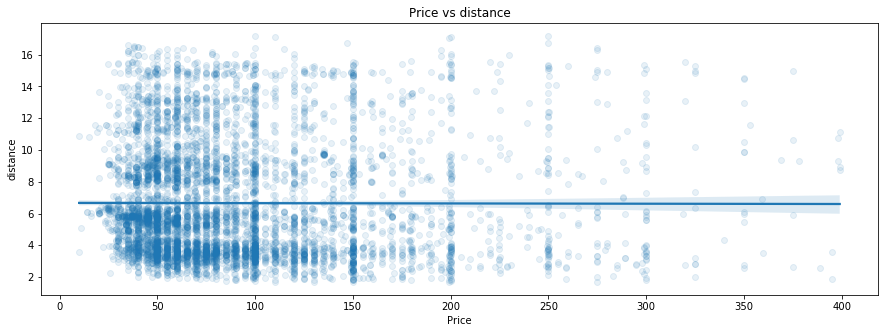

In [21]:
# Price vs Distance Queens

plt.figure(figsize=(15, 5))
sb.regplot(data = Queens, x = "Price", y = 'distance', x_jitter = 0.1, 
            scatter_kws = {'alpha': 0.1})
plt.title('Price vs distance')

Text(0.5, 1.0, 'Price vs distance')

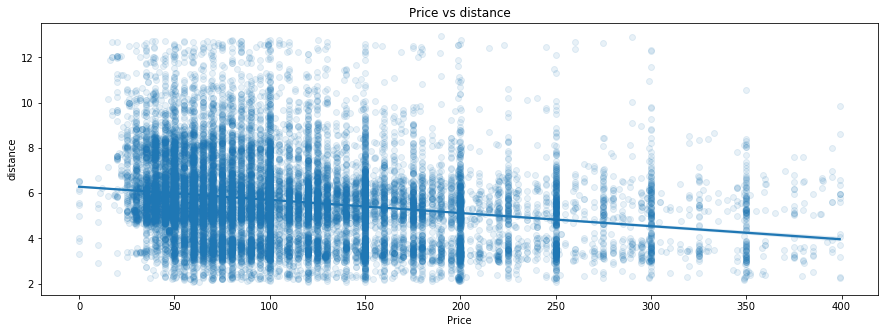

In [22]:
# Price vs Distance Brooklyn

plt.figure(figsize=(15, 5))
sb.regplot(data = Brooklyn, x = "Price", y = 'distance', x_jitter = 0.1, 
            scatter_kws = {'alpha': 0.1})
plt.title('Price vs distance')

Text(0.5, 1.0, 'Price vs distance')

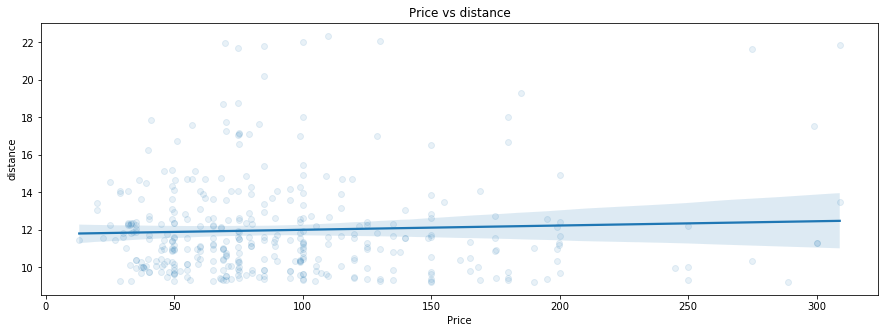

In [23]:
# Price vs Distance Staten Island

plt.figure(figsize=(15, 5))
sb.regplot(data = StatenIsland, x = "Price", y = 'distance', x_jitter = 0.1, 
            scatter_kws = {'alpha': 0.1})
plt.title('Price vs distance')

# Room Type Exploratory and Analysis

In [24]:
EntireRoom = df[df['Room_Type']=='Entire home/apt']
PrivateRoom = df[df['Room_Type']=='Private room']
SharedRoom = df[df['Room_Type'] == 'Shared room']
HotelRoom = df[df['Room_Type'] == 'Hotel room']

Text(0.5, 1.0, 'Price vs distance')

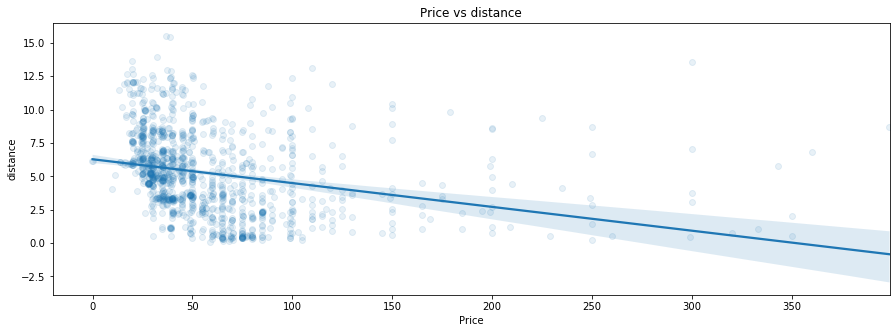

In [25]:
# Price vs Distance Shared Room

plt.figure(figsize=(15, 5))
sb.regplot(data = SharedRoom, x = "Price", y = 'distance', x_jitter = 0.1, 
            scatter_kws = {'alpha': 0.1})
plt.title('Price vs distance')

Text(0.5, 1.0, 'Price vs distance')

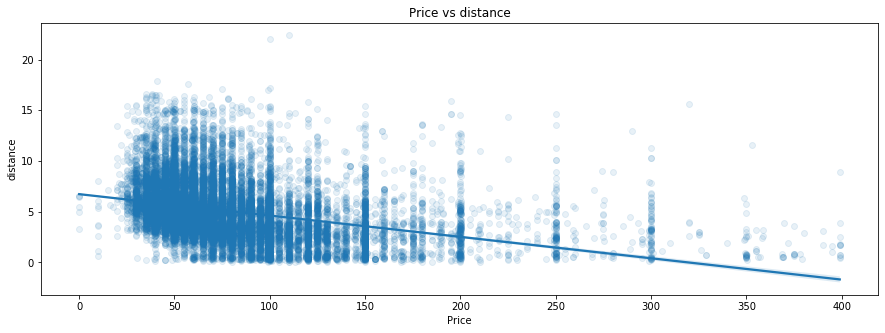

In [26]:
# Price vs Distance Private Room

plt.figure(figsize=(15, 5))
sb.regplot(data = PrivateRoom, x = "Price", y = 'distance', x_jitter = 0.1, 
            scatter_kws = {'alpha': 0.1})
plt.title('Price vs distance')

Text(0.5, 1.0, 'Price vs distance')

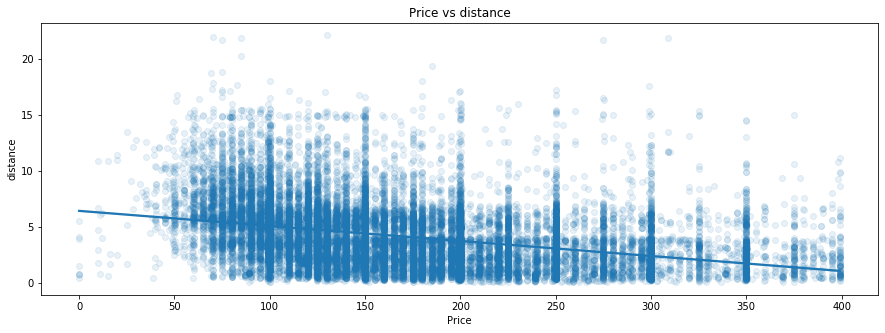

In [27]:
# Price vs Distance Entire Home

plt.figure(figsize=(15, 5))
sb.regplot(data = EntireRoom, x = "Price", y = 'distance', x_jitter = 0.1, 
            scatter_kws = {'alpha': 0.1})
plt.title('Price vs distance')

Text(0.5, 1.0, 'Price vs distance')

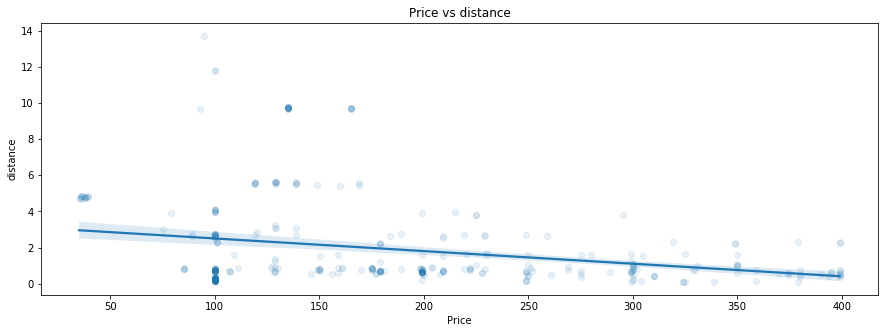

In [28]:
# Price vs Distance HotelRoom

plt.figure(figsize=(15, 5))
sb.regplot(data = HotelRoom, x = "Price", y = 'distance', x_jitter = 0.1, 
            scatter_kws = {'alpha': 0.1})
plt.title('Price vs distance')

In [134]:
# sb.pairplot(Manhattan, hue='Price', size=2.5);

# Encoding Categorical fields

In [29]:
# Column list by data type
g = df.columns.to_series().groupby(df.dtypes).groups
g

{dtype('int32'): Index(['host_response_rate'], dtype='object'),
 dtype('int64'): Index(['accommodates', 'beds', 'security_deposit', 'cleaning_fee',
        'guests_included', 'availability_365', 'number_of_reviews',
        'Review_Rating', 'review_scores_cleanliness', 'review_scores_value'],
       dtype='object'),
 dtype('float64'): Index(['latitude', 'longitude', 'bathrooms', 'bedrooms', 'Price',
        'weekly_price', 'monthly_price', 'extra_people', 'distance'],
       dtype='object'),
 dtype('O'): Index(['Superhost', 'Borough', 'Room_Type', 'bed_type', 'location'], dtype='object')}

In [30]:
# Assign X (data) and y (target)
X = df.drop(['Price', 'location', 'Superhost', 'bed_type', 'Room_Type', 'Borough'], axis=1)

y = df ["Price"]
print(X.shape, y.shape)

(48568, 19) (48568,)


In [165]:
# cat_cols = ['Superhost', 'Borough',
#         'Room_type', 'bed_type']

In [166]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='sag')
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(classifier, X, y, cv=5, scoring='accuracy').mean()

c:\users\cheikh_moctar\documents\ucf_bootcamp\ripos_git\class_repo\env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [160]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import make_column_transformer
# from sklearn.pipeline import make_pipeline

# # x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
# column_tranf = make_column_transformer((OneHotEncoder(), cat_cols), remainder='passthrough')

# column_tranf.fit_transform(x_train)

In [161]:
# pipe = make_pipeline(column_tranf, classifier)

In [162]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(pipe, x_train, y_train, cv=5, scoring='accuracy').mean()

c:\users\cheikh_moctar\documents\ucf_bootcamp\ripos_git\class_repo\env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\cheikh_moctar\documents\ucf_bootcamp\ripos_git\class_repo\env\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: A given column is not a column of the dataframe

  FitFailedWarning)


nan

In [163]:
# column_tranf

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('onehotencoder',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=True),
                                 ['Superhost', 'Borough', 'Room_type',
                                  'bed_type'])],
                  verbose=False)

# Decision Tree Classifier

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)
# tree = DecisionTreeClassifier()
# tree.fit(x_train, y_train)
# train_preds = tree.predict(x_train)
# test_preds = tree.predict(x_test)

In [32]:
# Using Decision Tree Model
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.0670166769610871

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(x_train, y_train)
rf.score(x_test, y_test)

In [ ]:
feature_names = x.columns
sorted(zip(rf.feature_importances_, feature_names), reverse=True)